# Receiver Operating Characteristic (ROC) with cross validation
- cross-validation을 사용하여 Receiver Operating Characteristic(ROC) 지표의 분산을 추정하고 시각화

## Load and prepare data

In [1]:
import numpy as np

from sklearn.datasets import load_iris

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

In [2]:
random_state = np.random.RandomState(0)
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)

### Classification and ROC analysis

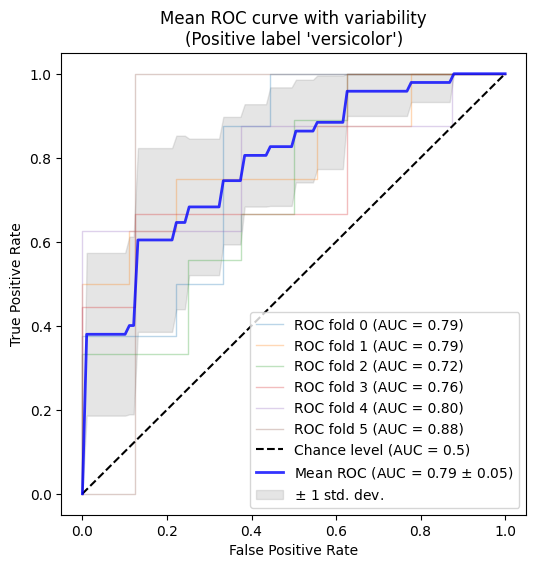

In [3]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
)
ax.legend(loc="lower right")
plt.show()